In [ ]:
!nvidia-smi

Thu Jun 24 14:23:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    36W / 300W |   4339MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%matplotlib inline
 
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/MayaChallenge/
 
!easy_install GDAL
 
# !unzip ./DiscoverMayaChallenge_data.zip -d ./data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MayaChallenge
Searching for GDAL
Best match: GDAL 2.2.2
Adding GDAL 2.2.2 to easy-install.pth file

Using /usr/lib/python2.7/dist-packages
Processing dependencies for GDAL
Finished processing dependencies for GDAL


In [ ]:
from segmentation_transforms import Compose, RandomHorizontalFlip, RandomCrop, Normalize, RandomResize

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os

from osgeo import gdal, gdal_array

from pathlib import Path
from copy import copy
from torch.utils.data import Dataset, random_split
import torch
from torch import nn
from torchvision import transforms as T
from torch.nn import functional as F
from segmentation_transforms import Compose, RandomHorizontalFlip, RandomCrop, Normalize, RandomResize
import torchvision.transforms.functional as transforms_F

import pickle

from pathlib import Path

from chactun_dataset import ChactunDataset, UpsampleSentinelToLidar

mask_train_path = Path('./data/train_masks')
lidar_train_path = Path('./data/lidar_train')
sent1_train_path = Path('./data/Sentinel1_train')

In [ ]:
class DotDict(dict):
    def __getattr__(self, attr):
        return self.get(attr)
 
    def __setattr__(self, key, value):
        self.__setitem__(key, value)
 
config = DotDict()
config.resize_min = 256
config.resize_max = 256
config.crop_size = 256
config.pretrained = True
config.num_classes = len(ChactunDataset.classes)
config.batch_size = 4
config.epochs = 80
config.lr = 1e-3
config.momentum = 0.9
config.sentinel1_bands = None
config.sentinel2_bands = None

In [ ]:
!ls data

lidar_test   Sentinel1_test   Sentinel2_test   train_masks
lidar_train  Sentinel1_train  Sentinel2_train


In [ ]:
def get_transofrms(h_flip_prob, resize_min, resize_max, crop_size, mean, std):
    train_transform = Compose([        
        UpsampleSentinelToLidar(),
        RandomResize(resize_min, resize_max),
        RandomCrop(crop_size)
    ])
    test_transform = Compose([
        UpsampleSentinelToLidar()
    ])

    return train_transform, test_transform

def get_dataset(config, root='./data', val_size=0.25):
    train_transform, test_transform = get_transofrms(
        config.h_flip_prob,
        config.resize_min,
        config.resize_max,
        config.crop_size,
        config.mean,
        config.std
    )

    ds = ChactunDataset(root, is_train=True, transform=train_transform,
                        sentinel1_bands=config.sentinel1_bands,
                        sentinel2_bands=config.sentinel2_bands)
    train_ds, val_ds = random_split(ds, [len(ds) - int(len(ds) * val_size), 
                                        int(len(ds) * val_size)])

    test_ds = ChactunDataset(root, is_train=False, transform=test_transform,
                             sentinel1_bands=config.sentinel1_bands,
                             sentinel2_bands=config.sentinel2_bands)

    return train_ds, val_ds, test_ds

In [ ]:
from torch.utils.data import DataLoader

train_ds, val_ds, test_ds = get_dataset(config, './data')

train_dl = DataLoader(train_ds, batch_size=config.batch_size, shuffle=True, drop_last=True)
val_dl = DataLoader(val_ds, batch_size=config.batch_size, shuffle=True, drop_last=True)
test_dl = DataLoader(test_ds, batch_size=config.batch_size, drop_last=True)

In [ ]:
def discretize_segmentation_maps(probs, thresh):
    if thresh is None:
        thresh = [0.5, 0.5, 0.5]
    if isinstance(thresh, int):
        thresh = [thresh] * 3
    thresh = torch.from_numpy(np.array(thresh)).to(probs.device)
    return probs > thresh[:, None, None]
 
def get_ious(y_pred, y_true, thresh=None, eps=1e-7):
    y_pred = discretize_segmentation_maps(y_pred, thresh).float()
    y_true = y_true.float()
    with torch.no_grad():
        intersection = torch.sum(y_true * y_pred, dim=[2, 3])
        union = torch.sum(y_true, dim=[2, 3]) + torch.sum(y_pred, dim=[2, 3]) - intersection
        ious = ((intersection + + eps) / (union + eps)).mean(dim=0)
    return ious

## Сравнение более старой модели UNet с DeepLabV3

## UNet
Сравним DeepLabV3 с более старым UNet.

Проверим [проиграет ли специалированная архитектура предобученной сети](https://www.azavea.com/blog/2019/08/30/transfer-learning-from-rgb-to-multi-band-imagery/) в нашем случае.


Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

Объявим основной блок сети

In [ ]:
def conv(inp, out, n=3, padding=1):
    layers = []
    for l in segment(inp, out, p=padding):
        layers.append(l)
    for _ in range(n-1):
        for l in segment(out, out, p=padding):
            layers.append(l)
 
    return nn.Sequential(*layers)
 
def segment(inp, out, k=3, p=1):
    return [
        nn.Conv2d(inp, out, k, padding=p),
        nn.BatchNorm2d(out),
        nn.ReLU()
    ]

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
 
        self.enc_conv0 = conv(8, 64, 2) # 
        self.pool0 = nn.MaxPool2d(2)  # 256 -> 128
 
        self.enc_conv1 = conv(64, 128, 2)
        self.pool1 = nn.MaxPool2d(2) # 128 -> 64
 
        self.enc_conv2 = conv(128, 256, 2)
        self.pool2 = nn.MaxPool2d(2) # 64 -> 32
 
        self.enc_conv3 = conv(256, 512, 2)
        self.pool3 = nn.MaxPool2d(2) # 32 -> 16
 
        # bottleneck
        self.bottleneck_conv = conv(512, 1024)
 
        # decoder (upsampling)
        self.upsample0 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(1024, 512, 3, padding=1),
        )
            # 16 -> 32
        self.dec_conv0 = conv(1024, 512, 2)
        self.upsample1 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, 3, padding=1),
        ) # 32 -> 64
        self.dec_conv1 = conv(512, 256, 2)
        self.upsample2 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, padding=1),
        ) # 64 -> 128
        self.dec_conv2 = conv(256, 128, 2)
        self.upsample3 = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, padding=1),
        ) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, config.num_classes, 1),
            nn.Sigmoid()
        )
 
    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e1 = self.enc_conv1(self.pool0(e0))
        e2 = self.enc_conv2(self.pool1(e1))
        e3 = self.enc_conv3(self.pool2(e2))
 
        # bottleneck
        b = self.bottleneck_conv(self.pool3(e3)) #16
        # decoder
        d0 = self.dec_conv0(torch.cat((e3, self.upsample0(b)),  dim=1))
        d1 = self.dec_conv1(torch.cat((e2, self.upsample1(d0)), dim=1))
        d2 = self.dec_conv2(torch.cat((e1, self.upsample2(d1)), dim=1))
        d3 = self.dec_conv3(torch.cat((e0, self.upsample3(d2)), dim=1))
        return d3

In [ ]:
from torch import optim
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet()
crit = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum)
sched = optim.lr_scheduler.OneCycleLR(optimizer, config.lr, 
                                      epochs=config.epochs, 
                                      steps_per_epoch=len(train_dl))
model = model.to(device)

In [ ]:
 !pip install wandb
 
import wandb
wandb.init(config=config)
wandb.watch(model, log_freq=100)

### Обучим UNet, сохраняя реузультаты в wandb

In [ ]:
from tqdm.notebook import tqdm, trange
 
for i in trange(config.epochs):
    model.train()
    for X, y in tqdm(train_dl):
        X = X.to(device)
        y = y.to(device)
 
        optimizer.zero_grad()
        pred = model(X)
        loss = crit(pred, y)
        loss.backward()
        optimizer.step()
        sched.step()
        
        #LOG metrics to wandb
        ious = get_ious(pred, y, config.prediction_thresh).cpu()
        metrics = {'iou_' + class_name: iou_score.item()
                for class_name, iou_score in zip(ChactunDataset.classes, ious)}
        metrics['avg_iou'] = ious.mean()
        metrics['loss'] = loss.item()
        metrics['lr'] = sched.get_last_lr()
        wandb.log(metrics)
 
    model.eval()
    losses = []
    ious = []
    for X, y in val_dl:
        X = X.to(device)
        y = y.to(device)
 
        with torch.no_grad():
            pred = model(X)
            losses.append(crit(pred, y).item())
            iou = get_ious(pred, y, config.prediction_thresh)
            ious.append(iou.cpu().numpy())
    metrics = {'val_iou_' + class_name: iou_score.item()
                for class_name, iou_score in zip(ChactunDataset.classes, np.stack(ious).mean(axis=0))}
    metrics['val_avg_iou'] = np.array(ious).mean(axis=0).mean()
    metrics['val_loss'] = np.mean(losses)
    wandb.log(metrics)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
torch.save(model.state_dict(), 'model_unet_weights-38.pth')

In [ ]:
wandb.run.finish()

## Результаты

Было проведено 2 эксперимента с UNet, написанным по статье, без предобучения. Также случайно был протестирован softmax в качестве функции активации на последнем слое, но он существенно ухудшил метрики

#### В первом эксперименте
На последнем слое использовался Softmax. Модель показывала низкие значения IoU ($0.4544$), а loss рано вышел на плато.

#### Во втором эксперименте 
Использовалась та же модель, но с сигмоидой на последнем слое. Были получены значения IoU близкие к baseline DeeplabV3. При этом UNet лидировал на валидационной выборке ($val\_avg\_iou 0.6586 > 0.5902
$)

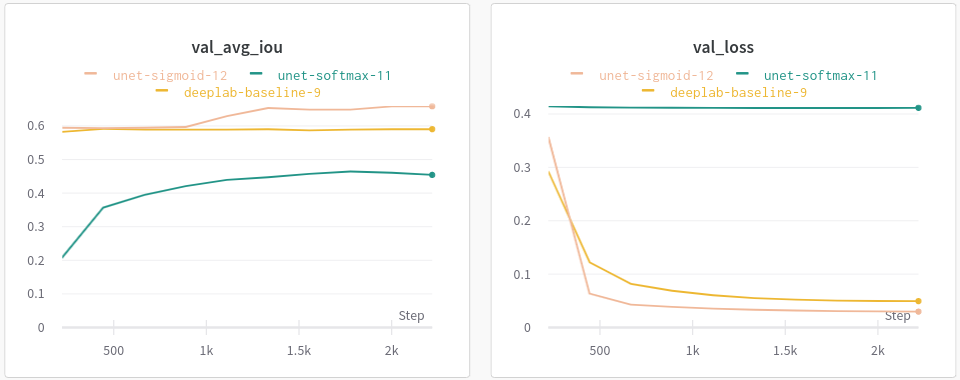